In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/4-1실전기계학습/final_project/dataset/FaceAge.zip -d ./dataset

Archive:  /content/drive/MyDrive/4-1실전기계학습/final_project/dataset/FaceAge.zip
replace ./dataset/test/00005.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


##**Import all neceassary packages**


In [ ]:
import os
import sys
import time
import torch
import numpy as np
from glob import glob
from PIL import Image

import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.notebook import tqdm as tqdm


##**Model - Define ResNet Model**

In [ ]:
'''ResNet18/34/50/101/152 in Pytorch.'''

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64) # 3x3 conv 적용
        self.bn1 = nn.BatchNorm2d(64) #BN 적용
        #_make_layer 함수를 이용해서 block이 포함된 layer들 생성
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=2)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.linear = nn.Linear(512,num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=10):
    #resnet18은 각 layer마다 block을 2개씩 사용하는데 이를 변형해서 3개씩 사용하게 변형함 (파라미터 2백만개에 가장 가깝게 유지하기 위함)
    return ResNet(BasicBlock, [3,3,3,3], num_classes)

def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3,4,6,3], num_classes)

def ResNet50(num_classes=10):
    return ResNet(Bottleneck, [3,4,6,3], num_classes)

def ResNet101(num_classes=10):
    return ResNet(Bottleneck, [3,4,23,3], num_classes)

def ResNet152(num_classes=10):
    return ResNet(Bottleneck, [3,8,36,3], num_classes)

test_model = ResNet18(num_classes=1)
sum(p.numel() for p in test_model.parameters())

1952449

##**Utils**

In [ ]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    r"""Computes the accuracy over the $k$ top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # _, pred = output.topk(maxk, 1, True, True)
        # pred = pred.t()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))

        # faster topk (ref: https://github.com/pytorch/pytorch/issues/22812)
        _, idx = output.sort(descending=True)
        pred = idx[:,:maxk]
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [ ]:
import torch.nn.functional as F
import math
from math import pi, cos, log, floor
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmRestarts(_LRScheduler):
    r"""Set the learning rate of each parameter group using a cosine annealing
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        T_0 (int): Number of iterations for the first restart.
        T_mult (int, optional): A factor increases :math:`T_{i}` after a restart. Default: 1.
        eta_min (float, optional): Minimum learning rate. Default: 0.
        last_epoch (int, optional): The index of last epoch. Default: -1.
        verbose (bool): If ``True``, prints a message to stdout for
            each update. Default: ``False``.
    """

    def __init__(self, optimizer, T_0, T_mult=1, eta_min=0, last_epoch=-1, verbose=False):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        self.T_0 = T_0
        self.T_i = T_0
        self.T_mult = T_mult
        self.eta_min = eta_min

        super(CosineAnnealingWarmRestarts, self).__init__(optimizer, last_epoch, verbose)

        self.T_cur = self.last_epoch

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        return [self.eta_min + (base_lr - self.eta_min) * (1 + math.cos(math.pi * self.T_cur / self.T_i)) / 2
                for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None and self.last_epoch < 0:
            epoch = 0

        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.T_cur = self.T_cur - self.T_i
                self.T_i = self.T_i * self.T_mult
        else:
            if epoch < 0:
                raise ValueError("Expected non-negative epoch, but got {}".format(epoch))
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
        self.last_epoch = math.floor(epoch)

        class _enable_get_lr_call:

            def __init__(self, o):
                self.o = o

            def __enter__(self):
                self.o._get_lr_called_within_step = True
                return self

            def __exit__(self, type, value, traceback):
                self.o._get_lr_called_within_step = False
                return self

        with _enable_get_lr_call(self):
            for i, data in enumerate(zip(self.optimizer.param_groups, self.get_lr())):
                param_group, lr = data
                param_group['lr'] = lr
                self.print_lr(self.verbose, i, lr, epoch)

        self._last_lr = [group['lr'] for group in self.optimizer.param_groups]


##**Parameter Settings**

In [ ]:
model = 'resnet18' # resnet18, resnet50, resnet101
batch_size = 64  # Input batch size for training (default: 128)
epochs = 150 # Number of epochs to train (default: 100)
learning_rate = 1e-4 # Learning rate
data_augmentation = True # Traditional data augmentation such as augmantation by flipping and cropping?
cutout = True # Apply Cutout?
n_holes = 1 # Number of holes to cut out from image
length = 16 # Length of the holes
seed = 0 # Random seed (default: 0)
num_classes = 1 ##regression
print_freq = 30
num_workers = 1
cuda = torch.cuda.is_available()
cudnn.benchmark = True  # Should make training should go faster for large models
train_val_ratio = 0.9

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

##**Load and preprocess data**

In [ ]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.

    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [ ]:
import torchvision

class FacialDataset(Dataset):
    def __init__(self, data_path):
        if not os.path.exists(data_path):
            raise Exception(f"[!] {self.data_path} not existed")
        self.imgs = []
        self.labels = []
        self.initial_transform = transforms.Compose([
            transforms.Resize((64,64)),
            transforms.ToTensor(),                                 
        ])
        self.transform_less = transforms.Compose([
            #transforms.RandomCrop((64, 64), padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomErasing(),
            #transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=15, interpolation=torchvision.transforms.InterpolationMode.BILINEAR),                               
        ])
        self.transform_many = transforms.Compose([
            #transforms.RandomCrop((96, 96), padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomErasing(),
            #transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=15, interpolation=torchvision.transforms.InterpolationMode.BILINEAR),                               
        ])
        self.age_path = sorted(glob(os.path.join(data_path, "*.*")))
        for pth in self.age_path:
          img = Image.open(pth)
          label = int(pth.split('_')[0].split('/')[-1])
          self.labels.append(label)
          self.imgs.append(self.initial_transform(img))

    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.labels[idx]

        if label in range(18, 40) :
          image = self.transform_many(image)
        else :
          image = self.transform_less(image)

        return image , label

    def __len__(self):
        return len(self.age_path)

def get_data_loader(data_path, batch_size, num_workers,train_val_ratio):
    full_dataset = FacialDataset(data_path)
    train_size = int(train_val_ratio * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
    torch.manual_seed(3334)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers, pin_memory=False)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=False,num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader

train_loader, val_loader = get_data_loader('/content/dataset/train',batch_size,num_workers,train_val_ratio)


##**Main Training**

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
model = ResNet18(num_classes=num_classes).cuda()
get_n_params(model)

1952449

In [ ]:
def custom_imshow(img): 
  img = img.numpy()
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.show()

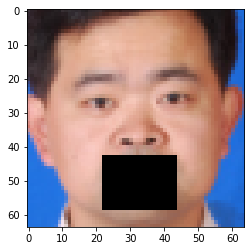

torch.Size([64, 3, 64, 64])


In [ ]:
import matplotlib.pyplot as plt

image , label = next(iter(train_loader))
custom_imshow(image[0])
print(image.shape)

In [ ]:
def train(train_loader, epoch, model, optimizer):
    batch_time = AverageMeter('Time', ':6.3f')
    l2 = AverageMeter('L2 Loss', ':.4e')
    l1 = AverageMeter('L1 Loss', ':.4e')
    progress = ProgressMeter(len(train_loader), batch_time, l2,l1, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.train()
    l1_criterion = nn.L1Loss().cuda()
    l2_criterion = nn.MSELoss().cuda()
    end = time.time()
    for i, (input, label) in enumerate(train_loader):
        # measure data loading time
        input = input.cuda()
        label = label.float().flatten().cuda()
        # compute output
        output = model(input).flatten()
        l2_ = l2_criterion(output, label)
        l1_ = l1_criterion(output,label)
        l2.update(l2_.item(), input.size(0))
        l1.update(l1_.item(), input.size(0))
        # compute gradient and do SGD step
        optimizer.zero_grad()
        l2_.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            progress.print(i)
    # print('==> Train Accuracy: Loss {losses:.3f} || scores {r2_score:.4e}'.format(losses=losses, r2_score=r2))

def validation(val_loader,epoch, model):
    model.eval()
    l2 = torch.nn.MSELoss().cuda()
    for i,(input,label) in enumerate(val_loader):
        input = input.cuda()
        label = label.float().flatten().cuda()
        output = model(input).flatten()
        l2_ = l2(label,output)
        RMSE = torch.sqrt(l2_)
    print('==> Validate Accuracy:  L2 distance {:.3f} || RMSE {:.3f}'.format(l2_,RMSE))
    return RMSE


###########################################################
model = ResNet18(num_classes=num_classes).cuda()

# Check number of parameters your model
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {pytorch_total_params}")
if int(pytorch_total_params) > 2000000:
    print('Your model has the number of parameters more than 2 millions..')
    sys.exit()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, nesterov=True, weight_decay=5e-4)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=LR, rho=0.9, eps=1e-06, weight_decay=5e-4)
# scheduler = MultiStepLR(optimizer, milestones=[60, 90, 120], gamma=0.2)
scheduler = CosineAnnealingWarmRestarts(optimizer, epochs, 1)
best_acc = 1e5
for epoch in range(epochs):
    print("\n----- epoch: {}, lr: {} -----".format(
        epoch, optimizer.param_groups[0]["lr"]))

    # train for one epoch
    start_time = time.time()
    train(train_loader, epoch, model, optimizer)
    val_acc = validation(val_loader,epoch,model)

    elapsed_time = time.time() - start_time
    print('==> {:.2f} seconds to train this epoch\n'.format(elapsed_time))
    # learning rate scheduling
    scheduler.step()
    
    # Save model for best accuracy
    if best_acc > val_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/4-1실전기계학습/random_model/model_best.pt')

    torch.save(model.state_dict(),'/content/drive/MyDrive/4-1실전기계학습/random_model/model_latest.pt')
print(f"Best RMSE Accuracy: {best_acc}")

Number of parameters: 1952449

----- epoch: 0, lr: 0.0001 -----
Epoch: [0][  0/613]	Time  0.262 ( 0.262)	L2 Loss 1.1622e+03 (1.1622e+03)	L1 Loss 3.0052e+01 (3.0052e+01)
Epoch: [0][ 30/613]	Time  0.031 ( 0.037)	L2 Loss 1.6531e+02 (2.4606e+02)	L1 Loss 8.9614e+00 (1.1212e+01)
Epoch: [0][ 60/613]	Time  0.029 ( 0.033)	L2 Loss 1.2865e+02 (2.2268e+02)	L1 Loss 9.0615e+00 (1.0580e+01)
Epoch: [0][ 90/613]	Time  0.026 ( 0.032)	L2 Loss 2.0201e+02 (2.1472e+02)	L1 Loss 9.9846e+00 (1.0346e+01)
Epoch: [0][120/613]	Time  0.028 ( 0.031)	L2 Loss 1.6679e+02 (2.0141e+02)	L1 Loss 9.7735e+00 (1.0013e+01)
Epoch: [0][150/613]	Time  0.028 ( 0.031)	L2 Loss 1.3863e+02 (1.9305e+02)	L1 Loss 7.9563e+00 (9.7718e+00)
Epoch: [0][180/613]	Time  0.028 ( 0.030)	L2 Loss 1.5933e+02 (1.8719e+02)	L1 Loss 8.2938e+00 (9.6549e+00)
Epoch: [0][210/613]	Time  0.026 ( 0.030)	L2 Loss 1.8353e+02 (1.8122e+02)	L1 Loss 8.5658e+00 (9.4962e+00)
Epoch: [0][240/613]	Time  0.027 ( 0.030)	L2 Loss 1.9410e+02 (1.7758e+02)	L1 Loss 9.2198e+00 (9.3

## Make an evalutation csv file

This code makes an evaluation csv file for Competition submission.

**Don't change below code!!!**

In [ ]:
class FacialDataset_test(Dataset):
    def __init__(self, data_path):
        if not os.path.exists(data_path):
            raise Exception(f"[!] {self.data_path} not existed")
        self.imgs = []
        self.transform = transforms.Compose([
            transforms.ToTensor(),                                 
            transforms.Resize((64,64))
        ])
        self.age_path = sorted(glob(os.path.join(data_path, "*.*")))
        for pth in self.age_path:
          img = Image.open(pth)
          self.imgs.append(self.transform(img))
    def __getitem__(self, idx):
        image = self.imgs[idx]
        return image

    def __len__(self):
        return len(self.age_path)

import torch
import pandas as pd
import argparse
import time
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

def eval():
    test_dataset = FacialDataset_test("/content/dataset/test")
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=1,shuffle=False)

    model = ResNet18(num_classes=num_classes).cuda()
    model.load_state_dict(torch.load('/content/drive/MyDrive/4-1실전기계학습/random_model/model_best.pt'))
    model.eval()
    
    print('Make an evaluation csv file for submission...')
    Category = []
    for input in test_loader:
        input = input.cuda()
        output = [model(input).item()]
        # output = torch.argmax(output, dim=1)
        Category = Category + output

    Id = list(range(0, len(test_loader)))
    samples = {
       'Id': Id,
       'Category': Category 
    }
    df = pd.DataFrame(samples, columns=['Id', 'Category'])

    df.to_csv('/content/drive/MyDrive/4-1실전기계학습/random_model/cutout_cosin_lr_submission_best.csv', index=False)
    print('Done!!')

    del model
    model = ResNet18(num_classes=num_classes).cuda()
    model.load_state_dict(torch.load('/content/drive/MyDrive/4-1실전기계학습/random_model/model_latest.pt'))
    model.eval()
    
    print('Make an evaluation csv file for submission...')
    Category = []
    for input in test_loader:
        input = input.cuda()
        output = [model(input).item()]
        # output = torch.argmax(output, dim=1)
        Category = Category + output

    Id = list(range(0, len(test_loader)))
    samples = {
       'Id': Id,
       'Category': Category 
    }
    df = pd.DataFrame(samples, columns=['Id', 'Category'])

    df.to_csv('/content/drive/MyDrive/4-1실전기계학습/random_model/cutout_cosin_lr_submission_latest.csv', index=False)
    print('Done!!')

if __name__ == "__main__":
    eval()

Make an evaluation csv file for submission...
Done!!
Make an evaluation csv file for submission...
Done!!
